## CAPM
> The CAPM is a financial model used to estimate the expected return of an asset based on its systematic risk. This notebook shows how to calculate the beta of a stock using simple linear regression and then use the CAPM to find the expected returns for Dollar General ($DG) and ExxonMobil ($XOM).

    Import the necessary libraries.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import quantfinanceHEC as qf
import seaborn as sns

    Fetch stock close price data, compute returns, and format return dataframe.

In [50]:
start_date = "2002-01-01"
end_date = "2022-01-01"

# Get close price data for dg, xom and spy
dg = qf.data_fetching.f_fetch_stock_data(symbol="dg", start_date=start_date, end_date=end_date, interval="daily")["4. close"] 
xom = qf.data_fetching.f_fetch_stock_data(symbol="xom", start_date=start_date, end_date=end_date, interval="daily")["4. close"] 
spy = qf.data_fetching.f_fetch_stock_data(symbol="spy", start_date=start_date, end_date=end_date, interval="daily")["4. close"] 

prices = pd.concat([dg, xom, spy], axis = 1) # Merge dataframes
prices.columns = ["dg", "xom", "spy"] # Rename columns

In [51]:
returns = prices.pct_change(fill_method=None) # Compute returns
returns = returns.dropna() # Drop NAs (first row)

    Compute the  daily and annual expected return for all securities.

In [52]:
# Daily expected return
daily_ev_dg = returns["dg"].mean() # Expected return for dg
daily_ev_xom = returns["xom"].mean() # Expected return for xom
daily_ev_spy = returns["spy"].mean() # Expected return for spy

trading_days = 252 # Nb trading days / year

# Annualized expected return
ann_ev_dg = (1 + daily_ev_dg) ** trading_days - 1
ann_ev_xom = (1 + daily_ev_dg) ** trading_days - 1 
ann_ev_spy = (1 + daily_ev_spy) ** trading_days - 1


    Compute $DG's beta by OLS.

In [53]:
model_dg = qf.linear_regression.f_multivariate_linear_regression(data=returns, dependent_vars=["dg"], independent_vars=["spy"])
_, beta_dg = model_dg.params # Alpha and Beta of Dollar General
beta_dg

0.5674117366568467

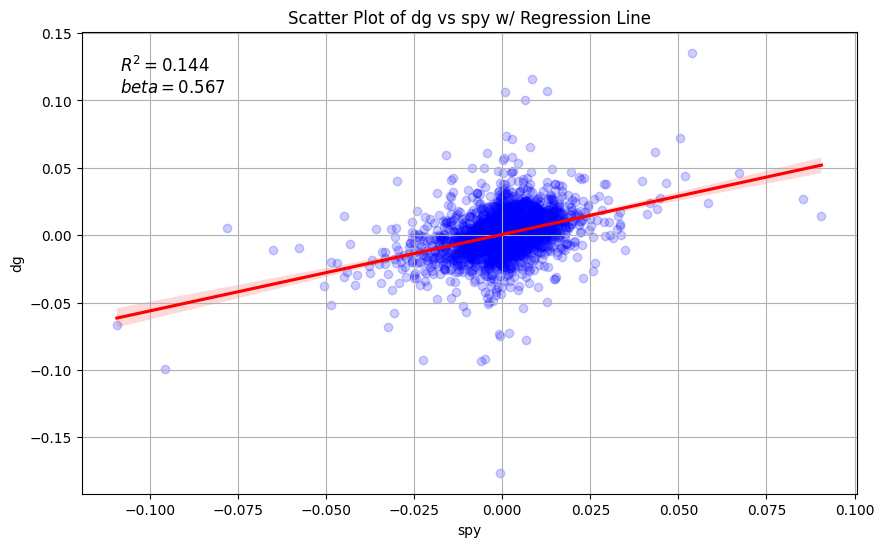

In [54]:
# Plotting the scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='spy', y='dg', data=returns, scatter_kws={'alpha':0.2, 'color':'blue'}, line_kws={'color':'red'})
plt.title('Scatter Plot of dg vs spy w/ Regression Line')
plt.xlabel('spy')
plt.ylabel('dg')
plt.grid(True)

# Adding the R^2 and beta value to the plot
plt.text(0.05, 0.95, f'$R^2 = {model_dg.rsquared:.3f}$', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'$beta = {beta_dg:.3f}$', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

plt.show()

    Similarly for $XOM.

In [55]:
model_xom = qf.linear_regression.f_multivariate_linear_regression(data=returns, dependent_vars=["xom"], independent_vars=["spy"])
_, beta_xom = model_xom.params # Alpha and Beta of Dollar General
beta_xom

0.984410944913652

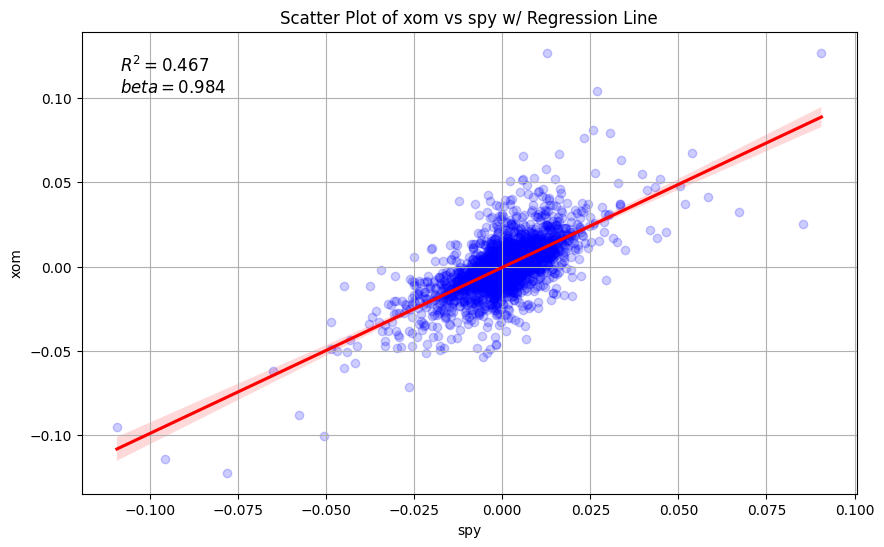

In [56]:
# Plotting the scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='spy', y='xom', data=returns, scatter_kws={'alpha':0.2, 'color':'blue'}, line_kws={'color':'red'})
plt.title('Scatter Plot of xom vs spy w/ Regression Line')
plt.xlabel('spy')
plt.ylabel('xom')
plt.grid(True)

# Adding the R^2 value to the plot
plt.text(0.05, 0.95, f'$R^2 = {model_xom.rsquared:.3f}$', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'$beta = {beta_xom:.3f}$', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

plt.show()

    As expected, $XOM's beta is significantly higher than $DG's. Remember that a stock with a beta of 1 can be interpret as follow: a 1% increase in the overall market is expected to lead to a 1% increase in the underlying.

    Additionally, we observe that the CAPM provides a "better fit" for XOM compared to DG, as reflected by the R-squared. We can interpret this as $XOM's performance being more closely tied to its exposure to systematic risk, which is why a greater percentage of its volatility is explained by overall market volatility.

In [57]:
import numpy as np

covariance_matrix = qf.performance_analytics.f_calculate_covariance_matrix(returns)
covariance_matrix


,dg,xom,spy
dg,0.000256,0.000045,0.000065
xom,0.000045,0.000237,0.000112
spy,0.000065,0.000112,0.000114


In [58]:
var_dg = covariance_matrix.iloc[0, 0]
var_spy = covariance_matrix.iloc[2, 2]
covar_dg_spy = covariance_matrix.iloc[0, 2] 
beta_dg_2 = covar_dg_spy / var_spy
(beta_dg_2 == beta_dg, beta_dg_2 - beta_dg)

(False, 3.3306690738754696e-16)

In [59]:
var_xom = covariance_matrix.iloc[1, 1]
covar_xom_spy = covariance_matrix.iloc[1, 2] 
beta_xom_2 = covar_xom_spy / var_spy
(beta_xom_2 == beta_xom, beta_xom_2 - beta_xom)



(True, 0.0)

    We can now use the CAPM model to get an estimate of xom's or dg's daily expected return.

In [83]:
rf = 0
ev_dg_capm = rf + beta_dg * (daily_ev_spy - rf)
ev_xom_capm = rf + beta_xom * (daily_ev_spy - rf)
print(f"CAPM expected return for $DG = {round(ev_dg_capm * trading_days * 100, 2)}%\nCAPM expected return for $XOM = {round(ev_xom_capm * trading_days * 100, 2)}%")

CAPM expected return for $DG = 7.69%
CAPM expected return for $XOM = 13.34%
